# Set Parameter
- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = [2, 50]
- Distance = [0, 96]
- Epochs = 100
- N = 100
- Data = 100K
- Deduplication

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))))

from trainer.supervised_trainer_without_eval import SupervisedTrainer_without_eval
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.evaluator import Evaluator

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Data load

In [3]:
train_path = "../../../data/bracket_dedup/K100/data_train.txt"

# Prepare dataset

In [4]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Prepare loss

In [5]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Variable definition

In [6]:
optimizer = "Adam"
hidden_sizes = list(range(2, 51, 4))
distance_list = []
bidirectional = True
print(hidden_sizes)
evaluator = Evaluator(loss=loss, batch_size=32)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]


In [7]:
for i in hidden_sizes:
    hidden_size = i
    print("hidden size is : %d" % hidden_size)
    seq2seq = None
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                         bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                         dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                         eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = SupervisedTrainer_without_eval(loss=loss, batch_size=32,
                                       checkpoint_every=50,
                                       print_every=100,
                                       hidden_size=hidden_size,
                                       path=str(hidden_size))

    seq2seq, ave_loss = t.train(seq2seq, train,
                                num_epochs=100, dev_data=None,
                                optimizer=optimizer,
                                teacher_forcing_ratio=0.5)
    
    distances = list(range(96, -1, -2))
    print(distances)
    for distance in distances:
        dev_path = "../../../data/bracket_dedup/K100/dev_distance/data_test_distance_" + str(distance) + ".txt"
        dev = torchtext.data.TabularDataset(
              path=dev_path, format='tsv',
              fields=[('src', src), ('tgt', tgt)],
              filter_pred=len_filter)
        dev_loss, character_accuracy, sentence_accuracy = evaluator.evaluate(seq2seq, dev)
        print("Distance:%d, Dev Loss:%0.4f, Character Accuracy:%0.4f, Sentence Accuracy:%0.4f\n"
                    % (distance, dev_loss, character_accuracy, sentence_accuracy))
        check_path = "../../../log/check_point/bracket_dedup_hidden_size_to_distance/hidden_size_" + str(hidden_size)
        with open(check_path, 'a') as f:
            f.write("Distance:%d, Dev Loss:%0.4f, Character Accuracy:%0.4f, Sentence Accuracy:%0.4f\n"
                    % (distance, dev_loss, character_accuracy, sentence_accuracy))
            
        if character_accuracy >= 0.95:
            distance_list.append(distance)
            break
        if distance == 0:
            distance_list.append(distance)

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-03-28 12:57:02,275 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


hidden size is : 2


/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-03-28 12:59:37,022 INFO   Finished epoch 1: Train loss: 20.8438
2019-03-28 13:02:12,098 INFO   Finished epoch 2: Train loss: 16.3069
2019-03-28 13:04:49,051 INFO   Finished epoch 3: Train loss: 23.9974
2019-03-28 13:07:25,519 INFO   Finished epoch 4: Train loss: 22.2143
2019-03-28 13:09:58,391 INFO   Finished epoch 5: Train loss: 16.9975
2019-03-28 13:12:32,059 INFO   Finished epoch 6: Train loss: 17.3374
2019-03-28 13:15:09,437 INFO   Finished epoch 7: Train loss: 19.9119
2019-03-28 13:17:42,461 INFO   Finished epoch 8: Train loss: 16.9950
2019-03-28 13:20:20,456 INFO   Finished epoch 9: Train loss: 16.9458
2019-03-28 13:22:54,774 INFO   Finished epoch 10: Train loss: 15.3700
2019-03-28 13:25:29,640 INFO   Finished epoch 11: Train loss: 14.4585
2019

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
Distance:96, Dev Loss:35.2668, Character Accuracy:0.2049, Sentence Accuracy:0.0000

Distance:94, Dev Loss:28.8515, Character Accuracy:0.2216, Sentence Accuracy:0.0000

Distance:92, Dev Loss:22.7288, Character Accuracy:0.2303, Sentence Accuracy:0.0000

Distance:90, Dev Loss:21.3154, Character Accuracy:0.2356, Sentence Accuracy:0.0000

Distance:88, Dev Loss:18.5098, Character Accuracy:0.2441, Sentence Accuracy:0.0000

Distance:86, Dev Loss:16.6494, Character Accuracy:0.2529, Sentence Accuracy:0.0000

Distance:84, Dev Loss:14.7645, Character Accuracy:0.2613, Sentence Accuracy:0.0000

Distance:82, Dev Loss:14.1874, Character Accuracy:0.2698, Sentence Accuracy:0.0000

Distance:80, Dev Loss:13.1534, Character Accuracy:0.2744, Sentence Accuracy:0.0000

Distance:78, Dev Loss:13.0957, Character Accuracy:0.

2019-03-28 17:23:29,029 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:2, Dev Loss:1.6248, Character Accuracy:0.7905, Sentence Accuracy:0.0000

Distance:0, Dev Loss:1.5232, Character Accuracy:0.9485, Sentence Accuracy:0.5455

hidden size is : 6


2019-03-28 17:26:04,885 INFO   Finished epoch 1: Train loss: 20.8086
2019-03-28 17:28:36,098 INFO   Finished epoch 2: Train loss: 19.9145
2019-03-28 17:31:07,792 INFO   Finished epoch 3: Train loss: 20.4274
2019-03-28 17:33:44,602 INFO   Finished epoch 4: Train loss: 15.4734
2019-03-28 17:36:22,841 INFO   Finished epoch 5: Train loss: 16.9618
2019-03-28 17:38:58,052 INFO   Finished epoch 6: Train loss: 13.1630
2019-03-28 17:41:35,999 INFO   Finished epoch 7: Train loss: 10.5332
2019-03-28 17:44:10,784 INFO   Finished epoch 8: Train loss: 10.2134
2019-03-28 17:46:45,895 INFO   Finished epoch 9: Train loss: 8.1343
2019-03-28 17:49:21,721 INFO   Finished epoch 10: Train loss: 7.9595
2019-03-28 17:51:58,084 INFO   Finished epoch 11: Train loss: 6.3300
2019-03-28 17:54:34,836 INFO   Finished epoch 12: Train loss: 5.4975
2019-03-28 17:57:11,016 INFO   Finished epoch 13: Train loss: 5.3191
2019-03-28 17:59:43,501 INFO   Finished epoch 14: Train loss: 5.3592
2019-03-28 18:02:19,985 INFO   Fini

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
Distance:96, Dev Loss:3.1588, Character Accuracy:0.5487, Sentence Accuracy:0.0000

Distance:94, Dev Loss:3.0337, Character Accuracy:0.5576, Sentence Accuracy:0.0000

Distance:92, Dev Loss:3.0473, Character Accuracy:0.5593, Sentence Accuracy:0.0000

Distance:90, Dev Loss:2.8966, Character Accuracy:0.5765, Sentence Accuracy:0.0000

Distance:88, Dev Loss:2.9646, Character Accuracy:0.5668, Sentence Accuracy:0.0000

Distance:86, Dev Loss:2.8666, Character Accuracy:0.5775, Sentence Accuracy:0.0000

Distance:84, Dev Loss:2.9312, Character Accuracy:0.5720, Sentence Accuracy:0.0000

Distance:82, Dev Loss:2.8504, Character Accuracy:0.5782, Sentence Accuracy:0.0000

Distance:80, Dev Loss:2.9013, Character Accuracy:0.5704, Sentence Accuracy:0.0000

Distance:78, Dev Loss:2.8024, Character Accuracy:0.5839, Sent

2019-03-28 21:46:03,713 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:6, Dev Loss:1.1344, Character Accuracy:0.9507, Sentence Accuracy:0.6667

hidden size is : 10


2019-03-28 21:48:37,170 INFO   Finished epoch 1: Train loss: 19.0386
2019-03-28 21:51:15,723 INFO   Finished epoch 2: Train loss: 16.0854
2019-03-28 21:53:56,245 INFO   Finished epoch 3: Train loss: 15.5963
2019-03-28 21:56:31,626 INFO   Finished epoch 4: Train loss: 16.6910
2019-03-28 21:59:00,143 INFO   Finished epoch 5: Train loss: 16.8538
2019-03-28 22:01:32,010 INFO   Finished epoch 6: Train loss: 11.4186
2019-03-28 22:04:08,643 INFO   Finished epoch 7: Train loss: 11.7909
2019-03-28 22:06:49,111 INFO   Finished epoch 8: Train loss: 10.5220
2019-03-28 22:09:27,991 INFO   Finished epoch 9: Train loss: 8.4671
2019-03-28 22:12:05,497 INFO   Finished epoch 10: Train loss: 7.0605
2019-03-28 22:14:44,044 INFO   Finished epoch 11: Train loss: 7.4645
2019-03-28 22:17:20,010 INFO   Finished epoch 12: Train loss: 7.4849
2019-03-28 22:19:55,938 INFO   Finished epoch 13: Train loss: 6.1683
2019-03-28 22:22:34,057 INFO   Finished epoch 14: Train loss: 5.9527
2019-03-28 22:25:11,243 INFO   Fini

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
Distance:96, Dev Loss:3.0282, Character Accuracy:0.5478, Sentence Accuracy:0.0000

Distance:94, Dev Loss:2.8161, Character Accuracy:0.5683, Sentence Accuracy:0.0000

Distance:92, Dev Loss:2.8821, Character Accuracy:0.5596, Sentence Accuracy:0.0000

Distance:90, Dev Loss:2.7285, Character Accuracy:0.5774, Sentence Accuracy:0.0000

Distance:88, Dev Loss:2.8058, Character Accuracy:0.5695, Sentence Accuracy:0.0000

Distance:86, Dev Loss:2.6907, Character Accuracy:0.5827, Sentence Accuracy:0.0000

Distance:84, Dev Loss:2.7489, Character Accuracy:0.5777, Sentence Accuracy:0.0000

Distance:82, Dev Loss:2.6806, Character Accuracy:0.5853, Sentence Accuracy:0.0000

Distance:80, Dev Loss:2.7512, Character Accuracy:0.5812, Sentence Accuracy:0.0000

Distance:78, Dev Loss:2.6503, Character Accuracy:0.5914, Sent

2019-03-29 02:10:22,203 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:12, Dev Loss:1.0890, Character Accuracy:0.9667, Sentence Accuracy:0.8770

hidden size is : 14


2019-03-29 02:12:58,824 INFO   Finished epoch 1: Train loss: 18.7779
2019-03-29 02:15:34,346 INFO   Finished epoch 2: Train loss: 16.8529
2019-03-29 02:18:11,225 INFO   Finished epoch 3: Train loss: 9.8283
2019-03-29 02:20:47,881 INFO   Finished epoch 4: Train loss: 5.0986
2019-03-29 02:23:27,352 INFO   Finished epoch 5: Train loss: 3.8385
2019-03-29 02:26:02,603 INFO   Finished epoch 6: Train loss: 3.4295
2019-03-29 02:28:37,140 INFO   Finished epoch 7: Train loss: 3.0784
2019-03-29 02:31:06,544 INFO   Finished epoch 8: Train loss: 2.8686
2019-03-29 02:33:42,606 INFO   Finished epoch 9: Train loss: 2.7405
2019-03-29 02:36:23,377 INFO   Finished epoch 10: Train loss: 2.6584
2019-03-29 02:38:58,008 INFO   Finished epoch 11: Train loss: 2.5138
2019-03-29 02:41:36,473 INFO   Finished epoch 12: Train loss: 2.4801
2019-03-29 02:44:16,443 INFO   Finished epoch 13: Train loss: 2.4341
2019-03-29 02:46:53,578 INFO   Finished epoch 14: Train loss: 2.3341
2019-03-29 02:49:30,773 INFO   Finished e

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
Distance:96, Dev Loss:2.1955, Character Accuracy:0.6956, Sentence Accuracy:0.0000

Distance:94, Dev Loss:2.0814, Character Accuracy:0.7117, Sentence Accuracy:0.0000

Distance:92, Dev Loss:2.0655, Character Accuracy:0.7140, Sentence Accuracy:0.0000

Distance:90, Dev Loss:1.9572, Character Accuracy:0.7301, Sentence Accuracy:0.0000

Distance:88, Dev Loss:1.9547, Character Accuracy:0.7328, Sentence Accuracy:0.0000

Distance:86, Dev Loss:1.8667, Character Accuracy:0.7454, Sentence Accuracy:0.0000

Distance:84, Dev Loss:1.8398, Character Accuracy:0.7532, Sentence Accuracy:0.0000

Distance:82, Dev Loss:1.7988, Character Accuracy:0.7620, Sentence Accuracy:0.0000

Distance:80, Dev Loss:1.7650, Character Accuracy:0.7693, Sentence Accuracy:0.0000

Distance:78, Dev Loss:1.7180, Character Accuracy:0.7805, Sent

2019-03-29 06:34:33,885 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:28, Dev Loss:1.0974, Character Accuracy:0.9646, Sentence Accuracy:0.6806

hidden size is : 18


2019-03-29 06:37:13,067 INFO   Finished epoch 1: Train loss: 18.3057
2019-03-29 06:39:48,994 INFO   Finished epoch 2: Train loss: 12.1649
2019-03-29 06:42:26,735 INFO   Finished epoch 3: Train loss: 4.9091
2019-03-29 06:45:07,119 INFO   Finished epoch 4: Train loss: 3.9061
2019-03-29 06:47:42,276 INFO   Finished epoch 5: Train loss: 3.3779
2019-03-29 06:50:19,052 INFO   Finished epoch 6: Train loss: 3.1463
2019-03-29 06:52:55,166 INFO   Finished epoch 7: Train loss: 2.7972
2019-03-29 06:55:35,092 INFO   Finished epoch 8: Train loss: 2.5937
2019-03-29 06:58:15,526 INFO   Finished epoch 9: Train loss: 2.4601
2019-03-29 07:00:54,465 INFO   Finished epoch 10: Train loss: 2.3546
2019-03-29 07:03:25,050 INFO   Finished epoch 11: Train loss: 2.2581
2019-03-29 07:05:59,063 INFO   Finished epoch 12: Train loss: 2.1857
2019-03-29 07:08:34,786 INFO   Finished epoch 13: Train loss: 2.1100
2019-03-29 07:11:09,318 INFO   Finished epoch 14: Train loss: 2.0646
2019-03-29 07:13:45,399 INFO   Finished e

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
Distance:96, Dev Loss:1.6029, Character Accuracy:0.8019, Sentence Accuracy:0.0000

Distance:94, Dev Loss:1.5627, Character Accuracy:0.8113, Sentence Accuracy:0.0000

Distance:92, Dev Loss:1.5653, Character Accuracy:0.8129, Sentence Accuracy:0.0000

Distance:90, Dev Loss:1.5204, Character Accuracy:0.8245, Sentence Accuracy:0.0000

Distance:88, Dev Loss:1.5190, Character Accuracy:0.8253, Sentence Accuracy:0.0000

Distance:86, Dev Loss:1.4777, Character Accuracy:0.8375, Sentence Accuracy:0.0000

Distance:84, Dev Loss:1.4698, Character Accuracy:0.8399, Sentence Accuracy:0.0000

Distance:82, Dev Loss:1.4382, Character Accuracy:0.8479, Sentence Accuracy:0.0000

Distance:80, Dev Loss:1.4249, Character Accuracy:0.8521, Sentence Accuracy:0.0000

Distance:78, Dev Loss:1.3911, Character Accuracy:0.8615, Sent

2019-03-29 11:01:15,313 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:52, Dev Loss:1.1209, Character Accuracy:0.9561, Sentence Accuracy:0.2867

hidden size is : 22


2019-03-29 11:03:58,183 INFO   Finished epoch 1: Train loss: 17.3349
2019-03-29 11:06:46,315 INFO   Finished epoch 2: Train loss: 12.9709
2019-03-29 11:09:24,705 INFO   Finished epoch 3: Train loss: 5.0951
2019-03-29 11:12:01,096 INFO   Finished epoch 4: Train loss: 3.5378
2019-03-29 11:14:40,924 INFO   Finished epoch 5: Train loss: 2.8506
2019-03-29 11:17:18,608 INFO   Finished epoch 6: Train loss: 2.4963
2019-03-29 11:19:58,356 INFO   Finished epoch 7: Train loss: 2.2271
2019-03-29 11:22:36,227 INFO   Finished epoch 8: Train loss: 2.0785
2019-03-29 11:25:13,877 INFO   Finished epoch 9: Train loss: 1.9421
2019-03-29 11:27:54,980 INFO   Finished epoch 10: Train loss: 1.8794
2019-03-29 11:30:32,476 INFO   Finished epoch 11: Train loss: 1.7640
2019-03-29 11:33:08,265 INFO   Finished epoch 12: Train loss: 1.7264
2019-03-29 11:35:43,313 INFO   Finished epoch 13: Train loss: 1.6559
2019-03-29 11:38:16,686 INFO   Finished epoch 14: Train loss: 1.5885
2019-03-29 11:40:47,558 INFO   Finished e

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
Distance:96, Dev Loss:1.1836, Character Accuracy:0.9495, Sentence Accuracy:0.0263



2019-03-29 15:26:35,207 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:94, Dev Loss:1.1527, Character Accuracy:0.9551, Sentence Accuracy:0.0339

hidden size is : 26


2019-03-29 15:29:21,395 INFO   Finished epoch 1: Train loss: 18.2234
2019-03-29 15:32:06,313 INFO   Finished epoch 2: Train loss: 10.8923
2019-03-29 15:34:48,838 INFO   Finished epoch 3: Train loss: 4.2329
2019-03-29 15:37:33,955 INFO   Finished epoch 4: Train loss: 3.3175
2019-03-29 15:40:13,099 INFO   Finished epoch 5: Train loss: 2.8067
2019-03-29 15:42:55,421 INFO   Finished epoch 6: Train loss: 2.4629
2019-03-29 15:45:37,999 INFO   Finished epoch 7: Train loss: 2.2290
2019-03-29 15:48:20,565 INFO   Finished epoch 8: Train loss: 2.0950
2019-03-29 15:51:07,992 INFO   Finished epoch 9: Train loss: 1.9590
2019-03-29 15:53:51,308 INFO   Finished epoch 10: Train loss: 1.8635
2019-03-29 15:56:31,309 INFO   Finished epoch 11: Train loss: 1.7769
2019-03-29 15:59:13,823 INFO   Finished epoch 12: Train loss: 1.6853
2019-03-29 16:02:00,195 INFO   Finished epoch 13: Train loss: 1.6085
2019-03-29 16:04:42,973 INFO   Finished epoch 14: Train loss: 1.5373
2019-03-29 16:07:25,365 INFO   Finished e

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]


2019-03-29 19:57:10,064 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:96, Dev Loss:1.0313, Character Accuracy:0.9914, Sentence Accuracy:0.6418

hidden size is : 30


2019-03-29 19:59:51,673 INFO   Finished epoch 1: Train loss: 20.3958
2019-03-29 20:02:30,875 INFO   Finished epoch 2: Train loss: 14.2891
2019-03-29 20:05:11,171 INFO   Finished epoch 3: Train loss: 6.5510
2019-03-29 20:07:51,048 INFO   Finished epoch 4: Train loss: 5.8800
2019-03-29 20:10:33,065 INFO   Finished epoch 5: Train loss: 4.6048
2019-03-29 20:13:15,993 INFO   Finished epoch 6: Train loss: 3.6298
2019-03-29 20:15:57,067 INFO   Finished epoch 7: Train loss: 2.8384
2019-03-29 20:18:38,004 INFO   Finished epoch 8: Train loss: 2.2947
2019-03-29 20:21:18,732 INFO   Finished epoch 9: Train loss: 2.0035
2019-03-29 20:23:59,927 INFO   Finished epoch 10: Train loss: 1.8296
2019-03-29 20:26:39,811 INFO   Finished epoch 11: Train loss: 1.7292
2019-03-29 20:29:20,562 INFO   Finished epoch 12: Train loss: 1.6270
2019-03-29 20:31:58,767 INFO   Finished epoch 13: Train loss: 1.5288
2019-03-29 20:34:41,145 INFO   Finished epoch 14: Train loss: 1.4804
2019-03-29 20:37:22,111 INFO   Finished e

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]


2019-03-30 00:24:53,803 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:96, Dev Loss:1.0465, Character Accuracy:0.9936, Sentence Accuracy:0.8105

hidden size is : 34


2019-03-30 00:27:38,594 INFO   Finished epoch 1: Train loss: 17.7321
2019-03-30 00:30:19,761 INFO   Finished epoch 2: Train loss: 11.9902
2019-03-30 00:33:01,441 INFO   Finished epoch 3: Train loss: 5.1005
2019-03-30 00:35:42,203 INFO   Finished epoch 4: Train loss: 3.3714
2019-03-30 00:38:24,140 INFO   Finished epoch 5: Train loss: 2.6157
2019-03-30 00:41:06,325 INFO   Finished epoch 6: Train loss: 2.2216
2019-03-30 00:43:48,181 INFO   Finished epoch 7: Train loss: 1.9696
2019-03-30 00:46:29,349 INFO   Finished epoch 8: Train loss: 1.7798
2019-03-30 00:49:12,943 INFO   Finished epoch 9: Train loss: 1.6521
2019-03-30 00:51:55,183 INFO   Finished epoch 10: Train loss: 1.5817
2019-03-30 00:54:37,922 INFO   Finished epoch 11: Train loss: 1.5147
2019-03-30 00:57:16,076 INFO   Finished epoch 12: Train loss: 1.4264
2019-03-30 00:59:55,779 INFO   Finished epoch 13: Train loss: 1.4017
2019-03-30 01:02:38,815 INFO   Finished epoch 14: Train loss: 1.3660
2019-03-30 01:05:20,353 INFO   Finished e

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]


2019-03-30 04:53:55,492 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:96, Dev Loss:1.0193, Character Accuracy:0.9977, Sentence Accuracy:0.9295

hidden size is : 38


2019-03-30 04:56:39,637 INFO   Finished epoch 1: Train loss: 16.6477
2019-03-30 04:59:17,738 INFO   Finished epoch 2: Train loss: 7.9915
2019-03-30 05:02:02,330 INFO   Finished epoch 3: Train loss: 3.5352
2019-03-30 05:04:41,188 INFO   Finished epoch 4: Train loss: 2.7425
2019-03-30 05:07:24,824 INFO   Finished epoch 5: Train loss: 2.2503
2019-03-30 05:10:08,173 INFO   Finished epoch 6: Train loss: 1.9074
2019-03-30 05:12:51,209 INFO   Finished epoch 7: Train loss: 1.7520
2019-03-30 05:15:34,068 INFO   Finished epoch 8: Train loss: 1.6083
2019-03-30 05:18:17,887 INFO   Finished epoch 9: Train loss: 1.5207
2019-03-30 05:21:00,010 INFO   Finished epoch 10: Train loss: 1.4257
2019-03-30 05:23:41,677 INFO   Finished epoch 11: Train loss: 1.4045
2019-03-30 05:26:24,489 INFO   Finished epoch 12: Train loss: 1.3560
2019-03-30 05:29:04,394 INFO   Finished epoch 13: Train loss: 1.2658
2019-03-30 05:31:47,309 INFO   Finished epoch 14: Train loss: 1.2461
2019-03-30 05:34:28,133 INFO   Finished ep

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]


2019-03-30 09:23:40,564 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:96, Dev Loss:1.0000, Character Accuracy:1.0000, Sentence Accuracy:1.0000

hidden size is : 42


2019-03-30 09:26:21,317 INFO   Finished epoch 1: Train loss: 15.6806
2019-03-30 09:29:03,590 INFO   Finished epoch 2: Train loss: 5.1287
2019-03-30 09:31:45,218 INFO   Finished epoch 3: Train loss: 3.2550
2019-03-30 09:34:31,346 INFO   Finished epoch 4: Train loss: 2.5752
2019-03-30 09:37:11,701 INFO   Finished epoch 5: Train loss: 2.2765
2019-03-30 09:39:52,479 INFO   Finished epoch 6: Train loss: 1.9554
2019-03-30 09:42:31,875 INFO   Finished epoch 7: Train loss: 1.7817
2019-03-30 09:45:11,556 INFO   Finished epoch 8: Train loss: 1.6342
2019-03-30 09:47:55,431 INFO   Finished epoch 9: Train loss: 1.5804
2019-03-30 09:50:40,336 INFO   Finished epoch 10: Train loss: 1.4790
2019-03-30 09:53:20,116 INFO   Finished epoch 11: Train loss: 1.4071
2019-03-30 09:56:01,727 INFO   Finished epoch 12: Train loss: 1.3554
2019-03-30 09:58:43,775 INFO   Finished epoch 13: Train loss: 1.3190
2019-03-30 10:01:23,466 INFO   Finished epoch 14: Train loss: 1.2666
2019-03-30 10:04:06,246 INFO   Finished ep

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
Distance:96, Dev Loss:8.8802, Character Accuracy:0.8873, Sentence Accuracy:0.0235

Distance:94, Dev Loss:9.3394, Character Accuracy:0.8882, Sentence Accuracy:0.0246



2019-03-30 13:53:52,786 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:92, Dev Loss:1.6816, Character Accuracy:0.9745, Sentence Accuracy:0.7871

hidden size is : 46


2019-03-30 13:56:34,357 INFO   Finished epoch 1: Train loss: 16.6921
2019-03-30 13:59:19,084 INFO   Finished epoch 2: Train loss: 5.6656
2019-03-30 14:02:02,529 INFO   Finished epoch 3: Train loss: 3.0816
2019-03-30 14:04:48,799 INFO   Finished epoch 4: Train loss: 2.4787
2019-03-30 14:07:33,707 INFO   Finished epoch 5: Train loss: 2.1470
2019-03-30 14:10:17,976 INFO   Finished epoch 6: Train loss: 1.9356
2019-03-30 14:13:00,774 INFO   Finished epoch 7: Train loss: 1.7547
2019-03-30 14:15:40,501 INFO   Finished epoch 8: Train loss: 1.6238
2019-03-30 14:18:22,906 INFO   Finished epoch 9: Train loss: 1.5544
2019-03-30 14:21:04,025 INFO   Finished epoch 10: Train loss: 1.4364
2019-03-30 14:23:46,016 INFO   Finished epoch 11: Train loss: 1.4410
2019-03-30 14:26:29,709 INFO   Finished epoch 12: Train loss: 1.3694
2019-03-30 14:29:14,131 INFO   Finished epoch 13: Train loss: 1.3243
2019-03-30 14:31:58,674 INFO   Finished epoch 14: Train loss: 1.3004
2019-03-30 14:34:38,175 INFO   Finished ep

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]


2019-03-30 18:24:43,484 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Distance:96, Dev Loss:1.0067, Character Accuracy:0.9987, Sentence Accuracy:0.9129

hidden size is : 50


2019-03-30 18:27:27,840 INFO   Finished epoch 1: Train loss: 14.0710
2019-03-30 18:30:11,631 INFO   Finished epoch 2: Train loss: 5.1750
2019-03-30 18:32:59,170 INFO   Finished epoch 3: Train loss: 3.3283
2019-03-30 18:35:43,947 INFO   Finished epoch 4: Train loss: 2.4996
2019-03-30 18:38:26,379 INFO   Finished epoch 5: Train loss: 2.2126
2019-03-30 18:41:10,380 INFO   Finished epoch 6: Train loss: 1.9764
2019-03-30 18:43:52,665 INFO   Finished epoch 7: Train loss: 1.7609
2019-03-30 18:46:37,878 INFO   Finished epoch 8: Train loss: 1.6485
2019-03-30 18:49:20,465 INFO   Finished epoch 9: Train loss: 1.5310
2019-03-30 18:52:04,295 INFO   Finished epoch 10: Train loss: 1.4608
2019-03-30 18:54:46,778 INFO   Finished epoch 11: Train loss: 1.3955
2019-03-30 18:57:29,609 INFO   Finished epoch 12: Train loss: 1.3365
2019-03-30 19:00:15,462 INFO   Finished epoch 13: Train loss: 1.3079
2019-03-30 19:02:57,735 INFO   Finished epoch 14: Train loss: 1.2311
2019-03-30 19:05:40,460 INFO   Finished ep

[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
Distance:96, Dev Loss:1.0156, Character Accuracy:0.9979, Sentence Accuracy:0.9710



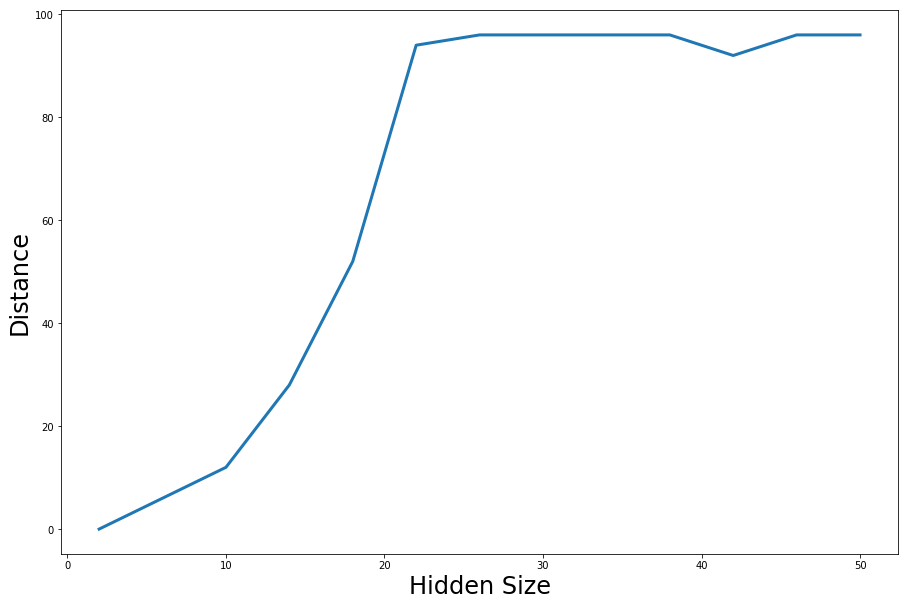

In [8]:
plt.figure(figsize=(15,10))
plt.plot(hidden_sizes, distance_list, LineWidth=3)
plt.xlabel('Hidden Size', fontsize=24)
plt.ylabel('Distance', fontsize=24)
plt.savefig('../../../log/plot/bracket_dedup_hidden_size_to_distance/bracket_dedup_hidden_size_to_distance.png')

In [9]:
print(hidden_sizes)
print(distance_list)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]
[0, 6, 12, 28, 52, 94, 96, 96, 96, 96, 92, 96, 96]
